In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import math

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5
plt.rcParams["font.size"] = 7

width=0.6

In [2]:
def aSum(lists):
    return [sum([l[ind] for l in lists]) for ind in range(len(lists[0]))]

In [3]:
def styleAx(ax, ytop, xleft, xright):
    ### set lim ###
    lo, hi = ax.get_ylim()
    if ytop is not None:
        hi = ytop
    left_lo = - hi * 0.2
    ax.set_ylim(left_lo, hi)
    ### set lim ###
    
    ### control spines ###
    ax.spines['bottom'].set_position('zero')
    #ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot(0, 1, "^k", transform=ax.transAxes, clip_on=False)
    
    ax.set_yticks([])
    
    ax.spines['left'].set_bounds(0, hi)
    
    return left_lo

In [4]:
def plotEditorAnynomize(ID, ax, msg='', ytop=None, width=3, alpha=0.5):
    
    colors = ['#00bfbf', '#ffa500', '#008000', '#ff0000']
    
    bad_papers = papers[papers.NewAuthorId == ID]
    bad_count = bad_papers.groupby(['Year','issn','during','edit']).PaperId.nunique().reset_index()
    
    x= [year for year in range(bad_count.Year.min(), bad_count.Year.max()+1, 5)]
    
    xleft=x[0]-4
    xright=x[-1]+4
    
    issn = list(bad_count.issn.unique())
    journals = [[] for i in issn]
    notj = []
    notedit = []
    
    if len(issn) == 1:
        issnlabel=["Published in editor's journal during editorship"]
    elif len(issn) == 2:
        issnlabel=["Editor's $1^{st}$ journal","Editor's $2^{nd}$ journal"]
    elif len(issn) == 3:
        issnlabel=["Editor's $1^{st}$ journal","Editor's $2^{nd}$ journal",
                  "Editor's $3^{rd}$ journal"]
    elif len(issn) == 4:
        issnlabel=["Editor's $1^{st}$ journal","Editor's $2^{nd}$ journal",
                   "Editor's $3^{rd}$ journal","Editor's $4^{th}$ journal"]
    else:
        print("ERROR!")

    for year in x:
        for ind, j in enumerate(issn):
            
            ### each COI journal ###
            df = bad_count[(bad_count.issn == j) &
                           (bad_count.Year >= year) &
                           (bad_count.Year < year+5) &
                           (bad_count.during == True) &
                           (bad_count.edit == True)
                          ]
            journals[ind].append(df.PaperId.sum())
            ### each COI journal ###
        
        ### other journals ###
        df = bad_count[(bad_count.Year >= year) &
                       (bad_count.Year < year+5) &
                       (bad_count.during == False) &
                       (bad_count.edit == True)]
        notj.append(df.PaperId.sum())
        ### other journals ###
        
        ### COI journal but not editing ###
        df = bad_count[(bad_count.Year >= year) &
                       (bad_count.Year < year+5) &
                       (bad_count.edit == False)]
        notedit.append(df.PaperId.sum())
        ### COI journal but not editing ###
        
    assert(bad_papers.shape[0] == bad_count.PaperId.sum())
    assert(bad_papers.shape[0] == sum(aSum(journals)) + sum(notj) + sum(notedit))
    
    def anonimize(l):
        return [max(_+np.random.normal(1, 0.5), _*0.5) if _!=0 else 0 for _ in l]
        
    # plot bars #
    journals = [anonimize(_) for _ in journals]
    notj = anonimize(notj)
    notedit = anonimize(notedit)
    
    ax.bar(x, journals[0], width, label=issnlabel[0], color=colors[0], alpha=alpha)
    for i in range(1, len(journals)):
        ax.bar(x, journals[i], width, label=issnlabel[i], color=colors[i], bottom=aSum(journals[:i]), alpha=alpha)
        
    if sum(notj) != 0:
        ax.bar(x, notj, width, bottom=aSum(journals), color='black', alpha=alpha,
               label="Published in editor's journal but not during editorship" )
    if sum(notedit) != 0:
        ax.bar(x, notedit, width, bottom=aSum([aSum(journals), notj]), color='grey', alpha=alpha,
                label='Other journals')
    # plot bars #
    
    ax.set_xticks([])
    
    left_lo = styleAx(ax, ytop, xleft, xright)
    multiplier = 0.55
    
    for ind, j in enumerate(issn):
        row = editors[(editors.NewAuthorId == ID) & (editors.issn == j)]
        left, right = int(row.start_year), int(row.end_year)
        ax.hlines(multiplier * left_lo, left, right, color=colors[ind], linewidths=1)
        
        ax.plot(left, multiplier * left_lo, "|", transform=ax.transData, clip_on=False, markersize=3, color=colors[ind])
        ax.plot(right, multiplier * left_lo, ">k", transform=ax.transData, clip_on=False, markersize=3, color=colors[ind])
        
        multiplier += 0.1
    
    ax.set_xlabel("Timeline of the editor's scientific career")
    ax.set_ylabel('Number of papers\nauthored by the editor')

In [5]:
def plotJournalAnynomize(issn, ax, ytop, middle=False, width=0.6, alpha=0.5):
    
    def anonimize(x):
        return max(x+np.random.normal(1, 0.5), x*0.5) if x != 0 else 0
    
    total = total_papers[total_papers.issn == issn]
    editor = editor_papers[editor_papers.issn == issn]
    
    running_b, running_t = 0, 0
    steps=[]
    
    MAX =  min(total.Year.max()+1, 2019)
    
    for year in range(total.Year.min(), MAX):
        bottom = editor[editor.Year == year].Count.values
        if len(bottom) != 0: bottom = bottom[0]
        else: bottom=0
            
        top = total[total.Year == year].Total.values
        if len(top) != 0: top = top[0]
        else: top=0
            
        anoBot = anonimize(bottom)
        
        ax.bar(year, anoBot, width, color='#5ac0c0', alpha=alpha,
                label='Paper authored by editor(s) of the journal')
        ax.bar(year, top-anoBot, width, color='gray', bottom=anoBot, alpha=alpha,
                label='Paper authored by other scientists')
        
        running_b += bottom
        running_t += top
        steps.append(running_b/running_t if top!=0 else 0)
        
    ax.legend(handles=[Patch(facecolor='#5ac0c0', alpha=0.5, label='Paper authored by editor(s) of the journal'),
                      Patch(facecolor='gray', alpha=0.5, label='Paper authored by other scientists')],
             loc='upper left')
    

    ax.set_xticks([])
    
    styleAx(ax, ytop, total.Year.min()-0.8*width, MAX-1+0.8*width)
    
    ax.set_ylabel('Number of papers\npublished in the journal')
    ax.set_xlabel("Timeline of the journal's lifespan")    

In [6]:
# left columns
papers = pd.read_csv('/scratch/fl1092/capstone/anonymize/figure_4/EditorPapers.csv',sep='\t',
                     dtype={'Year':int,'edit':bool,'during':bool,'EditorId':int,'IssnId':int,'AnoPaperId':int})
papers = papers.rename(columns={'EditorId':'NewAuthorId', 'IssnId':'issn', 'AnoPaperId':'PaperId'})

editors = pd.read_csv('/scratch/fl1092/capstone/anonymize/figure_4/Editors.csv',sep='\t',
                      dtype={'start_year':int,'end_year':int,'EditorId':int,'IssnId':int})
editors = editors.rename(columns={'EditorId':'NewAuthorId','IssnId':'issn'})

In [7]:
# right columns
editor_papers = pd.read_csv('/scratch/fl1092/capstone/anonymize/figure_4/EditorPapersInJournal.csv', sep='\t',
                           dtype={"IssnId":int,"Year":int,"Count":int})
editor_papers = editor_papers.rename(columns={'IssnId':'issn'})

total_papers = pd.read_csv('/scratch/fl1092/capstone/anonymize/figure_4/TotalPapersInJournal.csv', sep='\t',
                         dtype={"IssnId":int,"Year":int,"Count":int})
total_papers = total_papers.rename(columns={'IssnId':'issn'})

editor_papers.shape, total_papers.shape

((56, 3), (62, 3))

# Figure 4

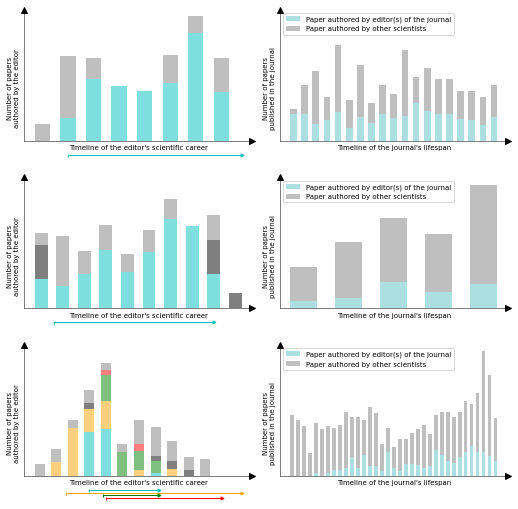

In [8]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(18.3*cm, 18*cm))
plt.rcParams.update({'font.size': 7})

ax = plt.subplot(3, 2, 1)
plotEditorAnynomize(12054, ax, '1st')

ax = plt.subplot(3, 2, 3)
plotEditorAnynomize(15203, ax, '2nd', 18)

ax = plt.subplot(3, 2, 5)
plotEditorAnynomize(13531, ax, '3rd', 60)

ax = plt.subplot(3, 2, 2)
plotJournalAnynomize(326, ax, 45)

ax = plt.subplot(3, 2, 4)
plotJournalAnynomize(1366, ax, 67, True)

ax = plt.subplot(3, 2, 6)
plotJournalAnynomize(6, ax, 82)

plt.tight_layout()

plt.savefig('../figures/4_anonymized.pdf', bbox_inches = 'tight', pad_inches = 0)

# Supplementary Figure

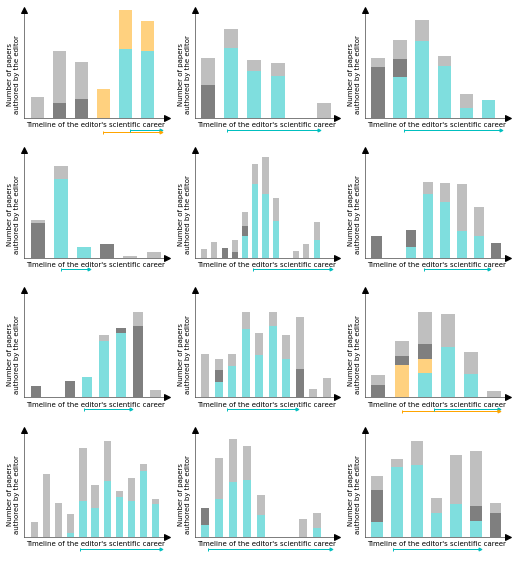

In [9]:
cm = 1/2.54
plt.figure(figsize=(18.3*cm, 20*cm))

ax = plt.subplot(4, 3, 1)
plotEditorAnynomize(9348, ax, ytop=15)

ax = plt.subplot(4, 3, 2)
plotEditorAnynomize(10693, ax, ytop=15)

ax = plt.subplot(4, 3, 3)
plotEditorAnynomize(12427, ax, ytop=20)

ax = plt.subplot(4, 3, 4)
plotEditorAnynomize(1357, ax, ytop=35)

ax = plt.subplot(4, 3, 5)
plotEditorAnynomize(13212, ax, ytop=25)

ax = plt.subplot(4, 3, 6)
plotEditorAnynomize(16872, ax, ytop=15)

ax = plt.subplot(4, 3, 7)
plotEditorAnynomize(16028, ax, ytop=20)

ax = plt.subplot(4, 3, 8)
plotEditorAnynomize(17518, ax, ytop=20)

ax = plt.subplot(4, 3, 9)
plotEditorAnynomize(2483, ax, ytop=30)

ax = plt.subplot(4, 3, 10)
plotEditorAnynomize(11631, ax, ytop=50)

ax = plt.subplot(4, 3, 11)
plotEditorAnynomize(6029, ax, ytop=20)

ax = plt.subplot(4, 3, 12)
plotEditorAnynomize(9357, ax, ytop=20)

plt.tight_layout()

plt.savefig('../figures/4_supplementary.pdf', bbox_inches = 'tight', pad_inches = 0)